### <span style="color:blue">TESTING FOR AND REMOVING TRENDS</span> <a class="anchor" id="ninth-bullet"></a>

#### <span style="color:blue">ROLLING STATISTICS METHOD</span> <a class="anchor" id="ninth-bullet"></a>

In [34]:
# Compute rolling mean and standard deviation
roll_mean = bitcoin_df.rolling(window=7).mean()
roll_std = bitcoin_df.rolling(window=7).std()

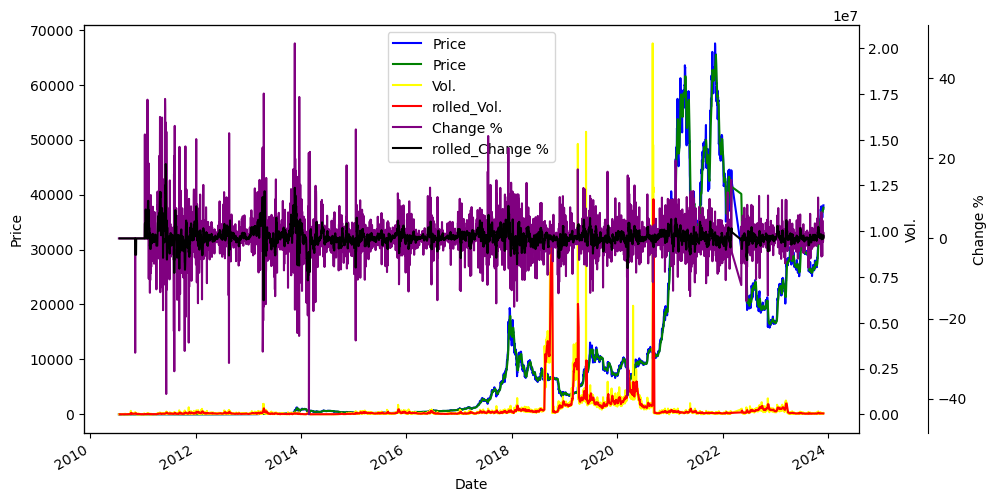

In [35]:
# Plot the rolling mean and original time series
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting 'Price' on the first axis
# bitcoin_df[['Price']].plot(ax=ax1, color='blue', label='Price')
# roll_mean[['Price']].plot(ax=ax1, color='green', label='rolled_price')
# ax1.set_ylabel('Price')

bitcoin_df[['Price']].plot(ax=ax1, color='blue', label='Price')
roll_mean[['Price']].plot(ax=ax1, color='green', label='Rolled Price')
ax1.set_ylabel('Price')

# Create a second y-axis for 'Vol.'
ax2 = ax1.twinx()
bitcoin_df['Vol.'].plot(ax=ax2, color='yellow', label='Vol.')
roll_mean['Vol.'].plot(ax=ax2, color='red', label='rolled_Vol.')
ax2.set_ylabel('Vol.')

# Create a third y-axis for 'Change %'
ax3 = ax1.twinx()
bitcoin_df['Change %'].plot(ax=ax3, color='purple', label='Change %')
roll_mean['Change %'].plot(ax=ax3, color='black', label='rolled_Change %')
ax3.spines['right'].set_position(('outward', 50))  # Adjust position for 'Change %' axis
ax3.set_ylabel('Change %')

# Adjusting layout and legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines_3, labels_3 = ax3.get_legend_handles_labels()
lines = lines_1 + lines_2 + lines_3
labels = labels_1 + labels_2 + labels_3
ax1.legend(lines, labels, loc='upper center');

Volume and Change features seem to have a seasonality while price has an exponentially increasing trend.

#### <span style="color:blue">DICKEY FULLER TEST</span> <a class="anchor" id="ninth-bullet"></a>

In [36]:
from statsmodels.tsa.stattools import adfuller

dftest_price = adfuller(bitcoin_df['Price'])
dftest_vol = adfuller(bitcoin_df['Vol.'])
dftest_change = adfuller(bitcoin_df['Change %'])

# Extract and display test results in a user friendly manner
for column, item in zip(bitcoin_df.columns, [dftest_price, dftest_vol, dftest_change]):
    dfoutput = pd.Series(item[0:4], index=['Test Statistic', 'p-value',
                                           '#Lags Used', 'Number of Observations Used'])
    for key, value in item[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(f'Results of Dickey-Fuller test for {column}:')
    print(f'{dfoutput}\n')

Results of Dickey-Fuller test for Price:
Test Statistic                   -1.275208
p-value                           0.640437
#Lags Used                       32.000000
Number of Observations Used    4773.000000
Critical Value (1%)              -3.431721
Critical Value (5%)              -2.862146
Critical Value (10%)             -2.567092
dtype: float64

Results of Dickey-Fuller test for Vol.:
Test Statistic                -8.961191e+00
p-value                        8.215929e-15
#Lags Used                     1.700000e+01
Number of Observations Used    4.788000e+03
Critical Value (1%)           -3.431717e+00
Critical Value (5%)           -2.862144e+00
Critical Value (10%)          -2.567091e+00
dtype: float64

Results of Dickey-Fuller test for Change %:
Test Statistic                -1.773806e+01
p-value                        3.411773e-30
#Lags Used                     1.000000e+01
Number of Observations Used    4.795000e+03
Critical Value (1%)           -3.431715e+00
Critical Value

By applying a **statistical significance level of 0.05**, we can conclude that volume (**p-value=8.215929e-15**) and change (**p-value=3.411773e-30**) are stationary while price (**p-value=0.640437**) is not stationary.

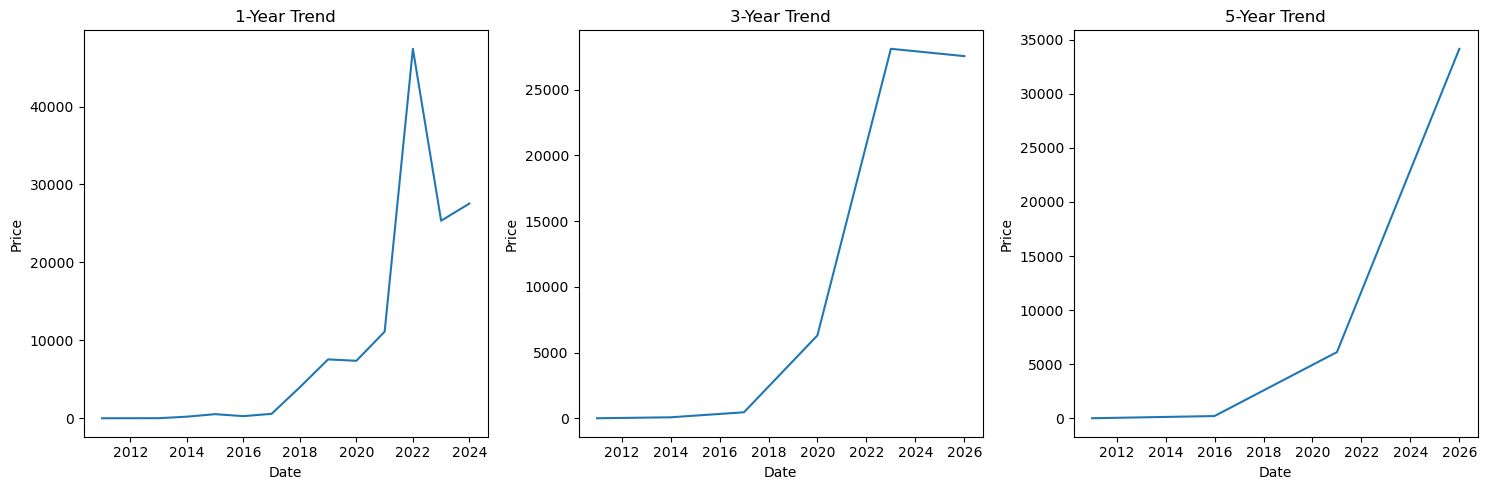

In [37]:
# Visualize 1-year, 3-year, and 5-year trends
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# 1-year trend
sns.lineplot(data=bitcoin_df['Price'].resample('1Y').mean(), ax=axes[0])
axes[0].set_title('1-Year Trend')

# 3-year trend
sns.lineplot(data=bitcoin_df['Price'].resample('3Y').mean(), ax=axes[1])
axes[1].set_title('3-Year Trend')

# 5-year trend
sns.lineplot(data=bitcoin_df['Price'].resample('5Y').mean(), ax=axes[2])
axes[2].set_title('5-Year Trend')

# Adjust layout
plt.tight_layout()
plt.show()

Downsampling the price series to 1-year, 3-year, and 5-year periods shows that it is an exponential trend. We will now decompose the price series to investigate seasonality.

#### <span style="color:blue">TIME SERIES DECOMPOSITION OF THE PRICE FEATURE</span> <a class="anchor" id="ninth-bullet"></a>

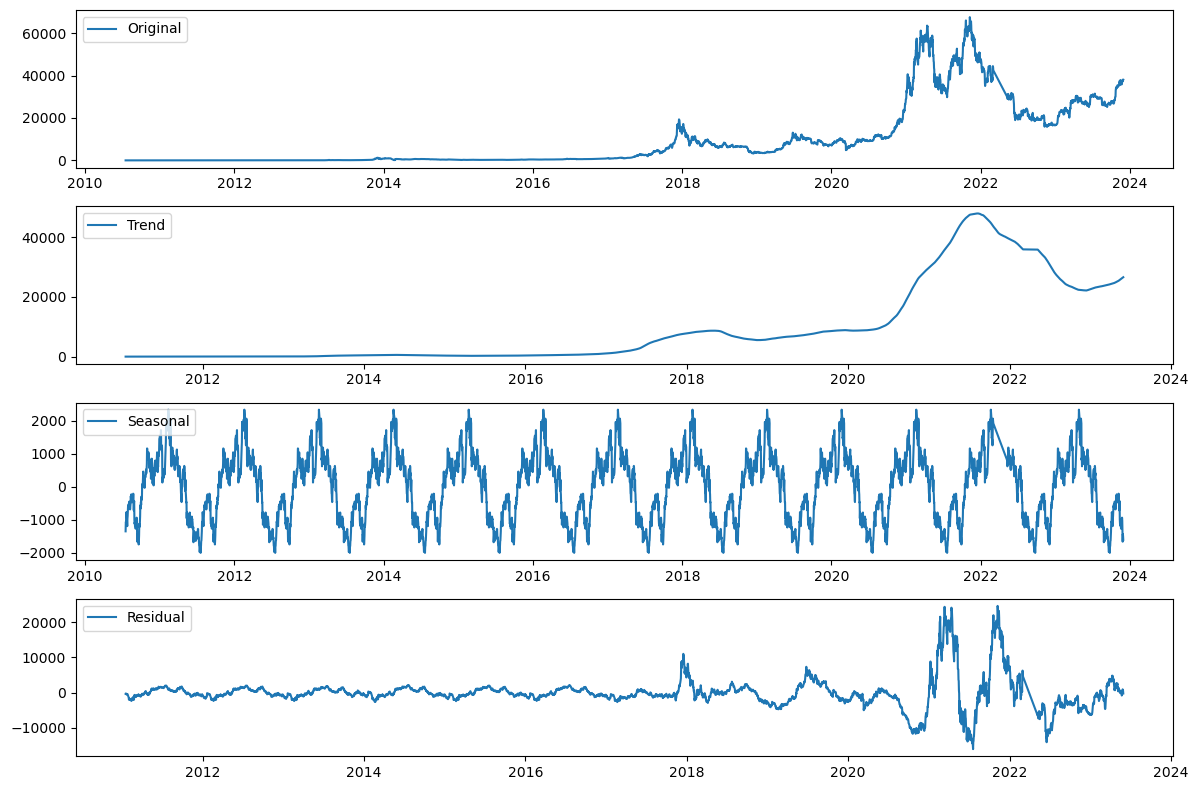

In [38]:
# Checking for Seasonality
# Seasonal decomposition using statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
tsd_result = seasonal_decompose(bitcoin_df['Price'], model='additive', period=365)  # Assuming annual seasonality

# Plot the original time series, trend, seasonal, and residual components
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(bitcoin_df['Price'], label='Original')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(tsd_result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(tsd_result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(tsd_result.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Time series decomposition reveals that the price feature has a trend and a yearly seasonality.

#### <span style="color:blue">1-LAG DIFFERENCING</span> <a class="anchor" id="ninth-bullet"></a>

We will apply differencing method to detrend the price feature.

In [39]:
# Differencing the price feature
price_diff = bitcoin_df['Price'].diff(periods=1)

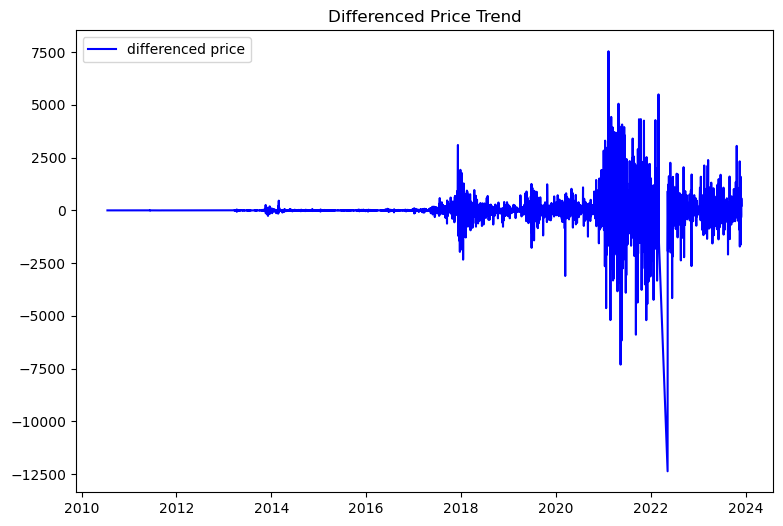

In [40]:
fig = plt.figure(figsize=(9, 6))
plt.plot(price_diff, color='blue',label='differenced price')
plt.legend(loc='best')
plt.title('Differenced Price Trend')
plt.show(block=False);

We will now test for the stationarity of the differenced price feature.

In [41]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(price_diff.dropna())

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value',
                                         '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print ('Results of Dickey-Fuller test for Price: \n')
print(dfoutput)

Results of Dickey-Fuller test for Price: 

Test Statistic                -1.037870e+01
p-value                        2.167409e-18
#Lags Used                     3.200000e+01
Number of Observations Used    4.772000e+03
Critical Value (1%)           -3.431721e+00
Critical Value (5%)           -2.862146e+00
Critical Value (10%)          -2.567093e+00
dtype: float64


The differenced price feature now has a p-value of 2.167409e-18, which means that it is now stationary.

We will replace the price column in the original dataset with the differenced price and remove rows with null values.

In [42]:
price_diff

Date
2010-07-18      NaN
2010-07-19      0.0
2010-07-20      0.0
2010-07-21      0.0
2010-07-22      0.0
              ...  
2023-11-25     69.7
2023-11-26   -335.2
2023-11-27   -203.2
2023-11-28    574.7
2023-11-29    223.4
Name: Price, Length: 4806, dtype: float64

In [43]:
# Replace Price feature with differenced price
bitcoin_diff = bitcoin_df.copy()
bitcoin_diff['Price'] = price_diff

# Drop null values
bitcoin_diff.dropna(inplace=True)

## <span style="color:blue">PART 3: TIME SERIES MODELLING</span> <a class="anchor" id="ninth-bullet"></a>

### <span style="color:blue">TRAIN TEST SPLIT</span> <a class="anchor" id="ninth-bullet"></a>

Differencing and time series decomposition have unique strengths and disadvantages.
1-lag differencing helps to remove the linear trend, which is necessary for models such as ARIMA.
Decomposition helps to remove both the trend and seasonality, which may make the series more stationary for better modelling.

We will therefore, create two sets of train test splits, one for 1-lag differenced series and the other for the residuals.

Since we intend to provide a six-week forecast, we will filter the last six weeks of the data and use it as the test set and the rest of the data will be the training set.

In [44]:
# Train test split for 1-lag differenced series
# Choose a split date
split_date = bitcoin_diff.tail(42).index[0].strftime('%m/%d/%Y') # Get the top 42nd index as a string

# Split train and test data
train_data_diff = bitcoin_diff[bitcoin_diff.index < split_date]
test_data_diff = bitcoin_diff[bitcoin_diff.index >= split_date]

In [45]:
# Train test split for residual series
# Drop null values from residual series
tsd_result.resid.dropna(inplace=True)

# Convert series to a dataframe and rename column as 'Price'
tsd_resid = pd.DataFrame(tsd_result.resid)
tsd_resid.rename(columns={'resid': 'Price'}, inplace=True)

# Choose a split date
split_date_resid = tsd_resid.tail(42).index[0].strftime('%m/%d/%Y') # Get the top 42nd index as a string

# Split train and test data
train_data_resid = tsd_resid[tsd_resid.index < split_date_resid]
test_data_resid = tsd_resid[tsd_resid.index >= split_date_resid]

### <span style="color:blue">BASELINE ARIMA MODEL</span> <a class="anchor" id="ninth-bullet"></a>

1-lag differencing helps to detrend the data, which is necessary for an ARIMA model. We will therefore, build an auto ARIMA model on the differenced train data.

Test RMSE: 860.367


C:\Users\USER PC\anaconda3\envs\stream-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\USER PC\anaconda3\envs\stream-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



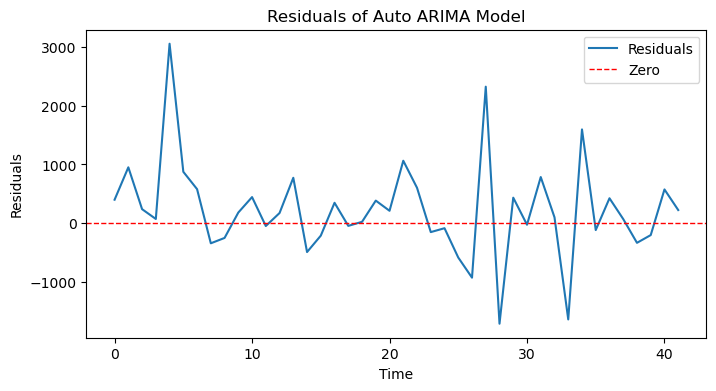

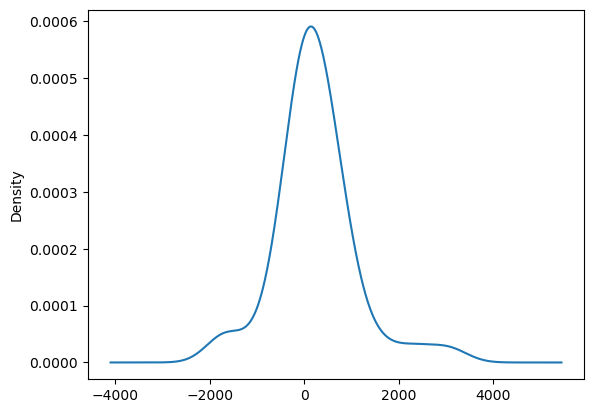

count      42.000000
mean      231.502851
std       838.680195
min     -1713.700000
25%      -143.800000
50%       176.750000
75%       542.050000
max      3057.599999
dtype: float64


In [46]:
# Fit a default auto ARIMA model on training data
model_default = auto_arima(train_data_diff['Price'], seasonal=False)

# Forecasting the same length as the test data
forecast_length = len(test_data_diff)
predictions = model_default.predict(n_periods=forecast_length)

# Calculate residuals
residuals = np.array([x for x in test_data_diff['Price']]) - np.array([x for x in predictions])

# Model evaluation
# Evaluate forecasts
predictions.index = test_data_diff.index
rmse = np.sqrt(mean_squared_error(test_data_diff['Price'], predictions))
print('Test RMSE: %.3f' % rmse)

# Plot residuals
plt.figure(figsize=(8, 4))
plt.plot(residuals, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1, label='Zero')
plt.title('Residuals of Auto ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Density plot of residuals
pd.Series(residuals).plot(kind='kde')
pyplot.show()
# Summary stats of residuals
print(pd.Series(residuals).describe())

In [47]:
# Auto ARIMA model with a few adjusted parameters
model_arima= auto_arima(train_data_diff['Price'], m=12, seasonal=True,
                     start_p=0, start_q=0, max_order=4, test='adf', error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise= True, trace= True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=75319.112, Time=1.43 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=75344.793, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=75337.708, Time=0.60 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=75338.606, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=75343.181, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=75338.971, Time=0.46 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=75338.126, Time=0.33 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=75315.091, Time=4.89 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=75325.613, Time=1.58 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=75296.014, Time=10.67 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=75314.517, Time=5.42 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=75296.327, Time=11.29 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=75296.425, Time=18.53 sec
 ARIMA(1,0,1)(2,0,2)[12] intercept   : AIC=75297.787, Time=22.20 sec
 

The best model found by the auto ARIMA search has no non-seasonal components (p=0, d=0, q=0), but it includes seasonal components (P=2, D=0, Q=2) with a seasonal period of 12, representing 12 months.

In [48]:
# Summary of fit model
print(model_arima.summary())

                                   SARIMAX Results                                   
Dep. Variable:                             y   No. Observations:                 4763
Model:             SARIMAX(2, 0, [1, 2], 12)   Log Likelihood              -37642.269
Date:                       Wed, 13 Dec 2023   AIC                          75294.538
Time:                               15:02:33   BIC                          75326.881
Sample:                                    0   HQIC                         75305.901
                                      - 4763                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -1.5746      0.037    -42.792      0.000      -1.647      -1.503
ar.S.L24      -0.7819      0.029    -27.327      0.000      -0.838      -0.

C:\Users\USER PC\anaconda3\envs\stream-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\USER PC\anaconda3\envs\stream-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



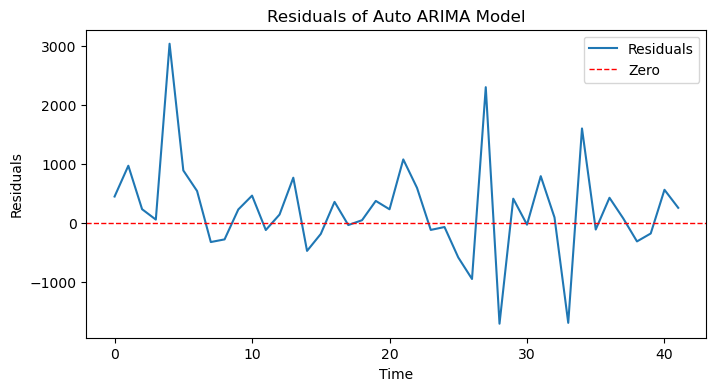

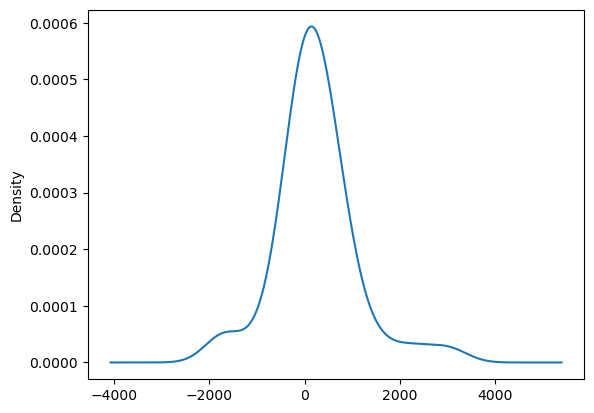

count      42.000000
mean      231.871813
std       837.950902
min     -1708.715732
25%      -120.889195
50%       183.892940
75%       520.178088
max      3034.710420
dtype: float64


In [49]:
# Forecasting the same length as the test data
forecast_length = len(test_data_diff)
predicted_data = model_arima.predict(n_periods=forecast_length)

# Calculate residuals
residuals = np.array([x for x in test_data_diff['Price']]) - np.array([x for x in predicted_data])

# Plot residuals
plt.figure(figsize=(8, 4))
plt.plot(residuals, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1, label='Zero')
plt.title('Residuals of Auto ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Density plot of residuals
pd.Series(residuals).plot(kind='kde')
pyplot.show()
# Summary stats of residuals
print(pd.Series(residuals).describe())

The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).

Test RMSE: 859.772


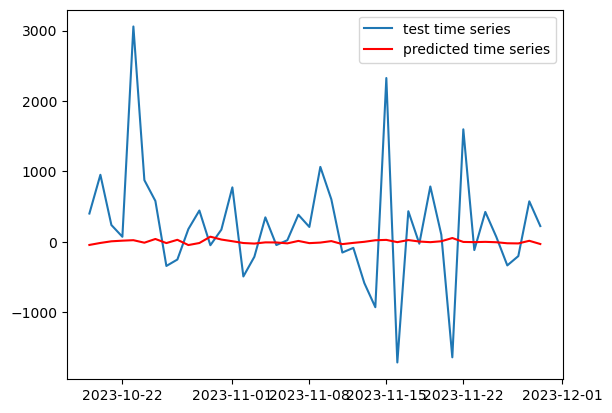

In [50]:
# Model evaluation
# Evaluate forecasts
predicted_data.index = test_data_diff.index
rmse = np.sqrt(mean_squared_error(test_data_diff['Price'], predicted_data))
print('Test RMSE: %.3f' % rmse)

# Plot forecasts against actual outcomes
pyplot.plot(test_data_diff['Price'], label= 'test time series')
pyplot.plot(predicted_data, color='red', label='predicted time series')
pyplot.legend()
pyplot.show()

The baseline ARIMA model has an RMSE of 859.772 which is high, and can explain why the predicted series is not as spurious as the original time series.

### <span style="color:blue">SARIMAX MODEL</span> <a class="anchor" id="ninth-bullet"></a>  

SARIMAX models extend the ARIMA framework by seamlessly integrating seasonal patterns and exogenous variables.

From the time series decomposition and auto ARIMA search, we noted that the price feature has a seasonality of one year, which is 365 days based on our series' frequency.

We will build a SARIMAX model on the differenced series.

C:\Users\USER PC\anaconda3\envs\stream-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\USER PC\anaconda3\envs\stream-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                   SARIMAX Results                                   
Dep. Variable:                         Price   No. Observations:                 4763
Model:             SARIMAX(2, 0, [1, 2], 12)   Log Likelihood              -37642.269
Date:                       Wed, 13 Dec 2023   AIC                          75294.538
Time:                               15:02:40   BIC                          75326.881
Sample:                                    0   HQIC                         75305.901
                                      - 4763                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -1.5746      0.037    -42.792      0.000      -1.647      -1.503
ar.S.L24      -0.7819      0.029    -27.327      0.000      -0.838      -0.

C:\Users\USER PC\anaconda3\envs\stream-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\USER PC\anaconda3\envs\stream-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



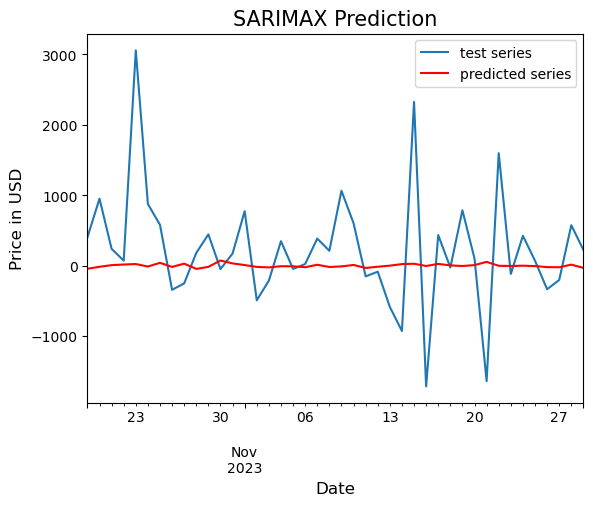

In [51]:
# Set best order as the values obtained via auto ARIMA
non_seasonal_order = (0, 0, 0)
best_seasonal_order = (2, 0, 2, 12)

# Fit SARIMA model with the best orders on train set
sarimax_model = SARIMAX(train_data_diff['Price'], order=non_seasonal_order, seasonal_order=best_seasonal_order)
sarima_fit = sarimax_model.fit()

# Display the summary of the model
print(sarima_fit.summary())

# Forecast for the specific number of days
forecast_days = len(test_data_diff)

# Perform the forecast
sarimax_pred = sarima_fit.get_forecast(steps=forecast_days)

# Extract predicted values
predicted_values = sarimax_pred.predicted_mean

# Calculate RMSE
rmse_arma = np.sqrt(mean_squared_error(test_data_diff['Price'], predicted_values))
print("\n")
print(f"SARIMA Model RMSE: {rmse_arma:.3f}")

# Change the forecast index to match the test data
predicted_values.index = test_data_diff.index

# Plot forecasts against actual outcomes
test_data_diff['Price'].plot(label= 'test series')
predicted_values.plot(color='red', label='predicted series')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price in USD', fontsize=12)
plt.title('SARIMAX Prediction', fontsize=15)
plt.legend()
plt.show()

The SARIMAX model has the same RMSE of 859.772 as the best ARIMA model.

### <span style="color:blue">FACEBOOK PROPHET MODEL</span> <a class="anchor" id="ninth-bullet"></a>  
Prophet is [a procedure for forecasting univariate time series data](https://github.com/facebook/prophet) based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data.

15:02:41 - cmdstanpy - INFO - Chain [1] start processing
15:02:42 - cmdstanpy - INFO - Chain [1] done processing


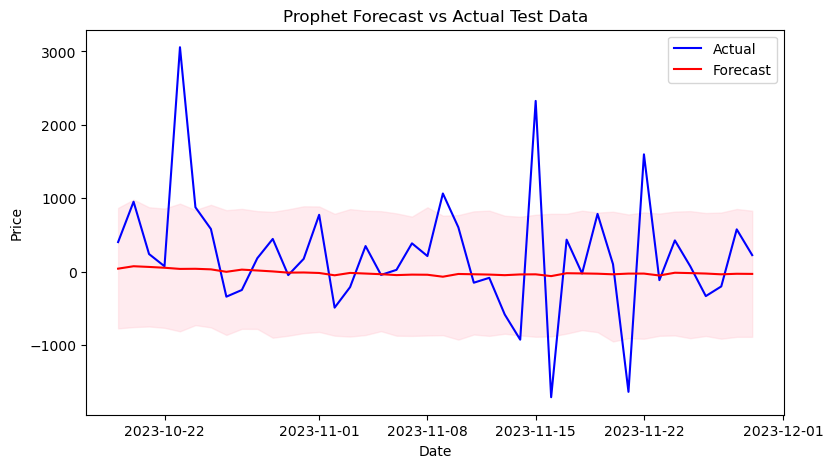

In [52]:
# Facebook model on 1-lag differenced series
# Find the last date in the training data
last_date = train_data_diff.index[-1]

# Increment the last date by one day to get the start date for forecasting
start_date = last_date + pd.DateOffset(days=1)

# Create a DataFrame with future dates starting from the next day
future = pd.DataFrame({'ds': pd.date_range(start=start_date, periods=42)})  # 42 days = 6 weeks

# Create and fit the Prophet model
prophet_data = train_data_diff.reset_index().rename(columns={'Date': 'ds', 'Price': 'y'})
fb_model = Prophet()
fb_model.fit(prophet_data)

# Generate forecasts
future_forecast = fb_model.predict(future)

# Plot the forecast vs the test dataset
# Merge the Prophet forecast with the differenced test_data
merged_df = pd.merge(test_data_diff, future_forecast[['ds', 'yhat',
                                                 'yhat_lower', 'yhat_upper']],
                     left_index=True, right_on='ds')

# Plot the actual test data and the forecast
plt.figure(figsize=(9, 5))

# Plot the actual test data
plt.plot(merged_df['ds'], merged_df['Price'], label='Actual', color='blue')

# Plot the forecast
plt.plot(merged_df['ds'], merged_df['yhat'], label='Forecast', color='red')

# Fill uncertainty intervals
plt.fill_between(merged_df['ds'], merged_df['yhat_lower'], merged_df['yhat_upper'],
                 color='pink', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Prophet Forecast vs Actual Test Data')
plt.legend();

Facebook prophet model evaluation.

In [53]:
# Evaluate forecasts
# Change the index of forecasted series
future_forecast = future_forecast.set_index('ds')
rmse = np.sqrt(mean_squared_error(test_data_diff['Price'], future_forecast['yhat']))
print('1-lag Differenced Test RMSE: %.3f' % rmse)

1-lag Differenced Test RMSE: 855.996


15:02:43 - cmdstanpy - INFO - Chain [1] start processing
15:02:43 - cmdstanpy - INFO - Chain [1] done processing


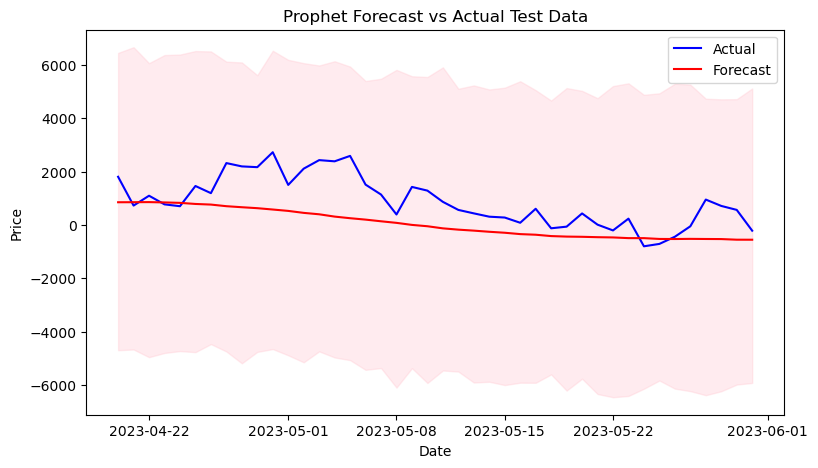

In [54]:
# Facebook model on residual series
# Find the last date in the training data
last_date = train_data_resid.index[-1]

# Increment the last date by one day to get the start date for forecasting
start_date = last_date + pd.DateOffset(days=1)

# Create a DataFrame with future dates starting from the next day
future = pd.DataFrame({'ds': pd.date_range(start=start_date, periods=42)})  # 42 days = 6 weeks

# Create and fit the Prophet model
prophet_data = train_data_resid.reset_index().rename(columns={'Date': 'ds', 'Price': 'y'})
fb_model = Prophet()
fb_model.fit(prophet_data)

# Generate forecasts
future_forecast = fb_model.predict(future)

# Plot the forecast vs the test dataset
# Merge the Prophet forecast with the differenced test_data
merged_df = pd.merge(test_data_resid, future_forecast[['ds', 'yhat',
                                                 'yhat_lower', 'yhat_upper']],
                     left_index=True, right_on='ds')

# Plot the actual test data and the forecast
plt.figure(figsize=(9, 5))

# Plot the actual test data
plt.plot(merged_df['ds'], merged_df['Price'], label='Actual', color='blue')

# Plot the forecast
plt.plot(merged_df['ds'], merged_df['yhat'], label='Forecast', color='red')

# Fill uncertainty intervals
plt.fill_between(merged_df['ds'], merged_df['yhat_lower'], merged_df['yhat_upper'],
                 color='pink', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Prophet Forecast vs Actual Test Data')
plt.legend();

In [55]:
# Evaluate forecasts
# Change the index of forecasted series
future_forecast = future_forecast.set_index('ds')
rmse = np.sqrt(mean_squared_error(test_data_resid['Price'], future_forecast['yhat']))
print('Residual Test RMSE: %.3f' % rmse)

Residual Test RMSE: 1078.537


The facebook prophet model is performing better on the 1-lag differenced series compared to the residuals. We will therefore go with the model built on the 1-lag differenced series.

The root mean squared error of the differenced series has improved from 859.772 with the ARIMA model to 855.996 with the Facebook Prophet model.